In [9]:
#!pip install pyenchant

In [20]:
import pandas as pd
import seaborn as sns
import numpy as np

import re

import enchant
from enchant.checker import SpellChecker

import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords

from collections import Counter
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import FreqDist
from nltk.util import ngrams
from nltk.corpus import brown
from collections import defaultdict

import collections
from operator import itemgetter
from gensim import corpora
from gensim.models.ldamodel import LdaModel

In [3]:
data = pd.read_csv('../data/train.csv')

In [4]:
data.head()

text_id                                          full_text  cohesion  \
0  0016926B079C  I think that students would benefit from learn...       3.5   
1  0022683E9EA5  When a problem is a change you have to let it ...       2.5   
2  00299B378633  Dear, Principal\n\nIf u change the school poli...       3.0   
3  003885A45F42  The best time in life is when you become yours...       4.5   
4  0049B1DF5CCC  Small act of kindness can impact in other peop...       2.5   

   syntax  vocabulary  phraseology  grammar  conventions  
0     3.5         3.0          3.0      4.0          3.0  
1     2.5         3.0          2.0      2.0          2.5  
2     3.5         3.0          3.0      3.0          2.5  
3     4.5         4.5          4.5      4.0          5.0  
4     3.0         3.0          3.0      2.5          2.5

In [5]:
data.describe()

cohesion       syntax   vocabulary  phraseology      grammar  \
count  3911.000000  3911.000000  3911.000000  3911.000000  3911.000000   
mean      3.127077     3.028254     3.235745     3.116850     3.032856   
std       0.662542     0.644399     0.583148     0.655997     0.699841   
min       1.000000     1.000000     1.000000     1.000000     1.000000   
25%       2.500000     2.500000     3.000000     2.500000     2.500000   
50%       3.000000     3.000000     3.000000     3.000000     3.000000   
75%       3.500000     3.500000     3.500000     3.500000     3.500000   
max       5.000000     5.000000     5.000000     5.000000     5.000000   

       conventions  
count  3911.000000  
mean      3.081053  
std       0.671450  
min       1.000000  
25%       2.500000  
50%       3.000000  
75%       3.500000  
max       5.000000

In [6]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3911 entries, 0 to 3910
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   text_id      3911 non-null   object 
 1   full_text    3911 non-null   object 
 2   cohesion     3911 non-null   float64
 3   syntax       3911 non-null   float64
 4   vocabulary   3911 non-null   float64
 5   phraseology  3911 non-null   float64
 6   grammar      3911 non-null   float64
 7   conventions  3911 non-null   float64
dtypes: float64(6), object(2)
memory usage: 244.6+ KB
None


In [7]:
def count_excl_quest_signs(text):
    return text.count("!") + text.count("?")

data['excl_quest_sign_count'] = data['full_text'].apply(count_excl_quest_signs)

In [8]:
def count_contractions(text):
    contractions = ["'s", "'t", "'d", "'ve", "'re", "'ll", "'m", "im" "youre", "youve", "youll", "youd", "shes",
                    "thatll", "dont", "shouldve", 'aren', "arent", 'couldn', 'cause', "thats", "cant", 
                    "couldnt", 'didn', "didnt", 'doesn', "doesnt", 'hadn', "hadnt", 'hasn', "hasnt", 'haven', "havent", 
                    'isn', "isnt", "'ma", 'mightn', "mightnt", 'mustn', "mustnt", 'needn', "neednt", 'shan', "shant", 
                    'shouldn', "shouldnt", 'wasn', "wasnt", 'weren', "werent", 'won', "wont", 'wouldn', "wouldnt"]
    count = 0
    for contr in contractions:
        count += text.lower().count(contr)
    return count

data['contractions_count'] = data['full_text'].apply(count_contractions)

In [10]:
def capitalized(text):
    mistake_counter = 0
    sentences = sent_tokenize(text)

    for i in sentences:
        if (i[0].islower()):
            mistake_counter+=1
            return (mistake_counter/len(sentences))

data['capitalized_mistakes'] = data.full_text.apply(capitalized)
data.fillna(0, inplace=True)

In [6]:
def count_words(text):
    words = text.split()
    return len(words)
    
def count_sentences(text):
    sentences = sent_tokenize(text)
    return len(sentences)

data['word_count'] = data.full_text.apply(count_words)
data['sentence_count'] = data.full_text.apply(count_sentences)

In [34]:
def text_to_paragraph(text):
    return list(filter(None, text.splitlines()))

data['paragraphs'] = data['full_text'].apply(lambda essay: text_to_paragraph(essay))

In [13]:
def paragraph_count(text):
    paragraphs = list(filter(None, text.splitlines()))
    paragraphs_list = [par for par in paragraphs if len(par.split()) > 3] # count only paragraphs which have more than 3 words
    return len(paragraphs_list)

data['paragraph_count'] = data['full_text'].apply(lambda essay: paragraph_count(essay))

In [14]:
def avg_word_count_per_paragraph(text):
    num_words = []
    for par in text:
        if (len(par.split()) > 3): # select only paragraphs which have more than 3 words
            num_words.append(len(par.split()))
    return sum(num_words)/len(num_words)

data['avg_word_count_per_paragraph'] = data['paragraphs'].apply(lambda paragraph: avg_word_count_per_paragraph(paragraph))

In [15]:
def avg_sentence_count_per_paragraph(text):
    num_sentences = []
    for par in text:
        if (len(par.split()) > 3): # select only paragraphs which have more than 3 words
            num_sentences.append(len(re.split(r'[.!?]+', par))-1)
            
    if any(number < 3 for number in num_sentences):
        short_sent = 1
    else: short_sent = 0
        
    return sum(num_sentences)/len(num_sentences), short_sent

data['avg_sentence_count_per_paragraph'] = data['paragraphs'].apply(lambda paragraph: avg_sentence_count_per_paragraph(paragraph)[0])
data['has_short_paragraphs'] = data['paragraphs'].apply(lambda paragraph: avg_sentence_count_per_paragraph(paragraph)[1])

In [16]:
def count_difficult_words(text):
    with open('../data/5000_sat_words.txt', mode='r') as file:
        sat_words = eval(file.read())

    word_count = 0
    for word in sat_words:
        if word in text.lower().split():
            word_count += 1
    return word_count

data["difficult_word_count"] = data["full_text"].apply(count_difficult_words)

In [14]:
punctuation = '!"#$%&\()*+,-./:;<=>?@[\\]^_{|}~'

def remove_punctuation(text):
    no_punct=[words for words in text if words not in punctuation]
    words_wo_punct=''.join(no_punct)
    return words_wo_punct

data['full_text_wo_punct'] = data['full_text'].apply(remove_punctuation)

In [18]:
def check_en_us_spelling(text):
    chkr = SpellChecker("en_UK","en_US")
    en_dict = enchant.Dict("en_US")
    
    misspelled_count = 0
    for word in text.split():
        if(en_dict.check(word) == False or word == 'u'):
            misspelled_count += 1

    return misspelled_count

data['spelling_mistake_count'] = data['full_text_wo_punct'].apply(check_en_us_spelling)

In [19]:
def spelling_mistakes_percent(text):
    return check_en_us_spelling(text)/count_words(text)
data['spelling_mistakes_percent'] = data['full_text_wo_punct'].apply(spelling_mistakes_percent)
data.drop('full_text_wo_punct', axis=1, inplace=True)

In [63]:
def count_unique_connectives(text):
    
    connectives = ['additionally', 'also', 'moreover', 'furthermore', 'again', 'further', 'then', 
                     'besides', 'too', 'similarly', 'correspondingly', 'indeed', 'regarding', 
                   'alternatively', 'although', 'otherwise', 'instead', 'whereas', 'conversely',
                   'therefore', 'accordingly','consequently', 'likewise', 'thus', 'hence', 
                    'since', 'despite', 'however', 'nevertheless', 'yet', 
                   'while', 'though', 'rather', 'subsequently', 'overall', 'conclusion', 'firstly', 
                   'first', 'secondly', 'second', 'thirdly', 'third', 'consequence' 
                   'namely', 'mainly', 'notably', 'particularly', 'especially', 'personally', 'unless',
                  'gradually', 'nonetheless']

    connectives_used = []
    
    for word in text.split():
        if word in connectives:
            connectives_used.append(word)
            
    connectives_counter = Counter(connectives_used)
    num_connectives_filtered = len({x: count for x, count in connectives_counter.items() if count < 10}) # do not include if used more than 10 times 
    return num_connectives_filtered

data['unique_linking_words_count'] = data['full_text'].apply(count_unique_connectives)

In [24]:
#func to check outliers
def too_big(df, column, percentile):
    big_columns = np.percentile(column, percentile)
    columns = df[column > big_columns]["full_text"]
    print(f"Percentile: {percentile}, columns have more than: {big_columns}")
    for i in columns:
        print ("Essay:")
        print (i)

In [25]:
def too_small(df,column, percentile):
    small_columns = np.percentile(column, percentile)
    columns = df[column < small_columns]["full_text"]
    print(f"Percentile: {percentile}, column have more than: {small_columns}")
    for i in columns:
        print ("Essay:")
        print (i)

In [26]:
def percentage_of_unique(text):
    num_words = len(text.split())
    num_unique_words = len(set(text.split()))
    return num_unique_words/num_words

data['percentage_of_unique_words'] = data['full_text'].apply(percentage_of_unique)

In [64]:
def count_unique_linking_phrases(text):
    
    two_word_phrases = ['in comparison', 'by contrast', 'evidence illustrates', 'this suggests',
                        'that implies', 'this implies', 'compared with', 'by contrast', 'after all',
                        'for example', 'for instance', 'such as', 'as follows', 'as exemplified', 
                        'in particular','in contrast', 'in conclusion', 'to conclude', 'to summarise',
                        'i think', 'i believe', 'insted of', 'apart from', 'above all', 'as with'
                       'in addition', 'to illustrate', 'in fact']
    
    three_word_phrases = ['another view is', 'as a result of', 'the result is', 'it can be seen',
                          'because of this', 'for this reason', 'for that reason', 'in that case',
                          'in this case',  'as a result', 'in spite of', 'point of view', 'on the whole', 
                          'the other hand', 'as well as', 'as long as', 'most of all', 'as shown by',
                         'as revealed by', 'as compared with', 'from here on', 'to begin with',
                         'last of all', 'in the end' , 'to be specific', 'on the whole', 
                          'of equal importance', 'as a consequence']
    
    no_punc_text = re.sub(r"[^\w\d'\s]+",' ', text)
    no_punc_text = no_punc_text.lower()
    
    bigrams = [' '.join(grams) for grams in nltk.ngrams(no_punc_text.split(), 2)]
    used_two_word_phrases = set()

    for gram in bigrams:
        if gram in two_word_phrases:
            used_two_word_phrases.add(gram)
            
    num_used_two_word_phrases = len(used_two_word_phrases)
    
    trigrams = [' '.join(grams) for grams in nltk.ngrams(no_punc_text.split(), 3)]
    used_three_word_phrases = set()
    
    for gram in trigrams:
        if gram in three_word_phrases:
            used_three_word_phrases.add(gram)
        
    num_used_three_word_phrases = len(used_three_word_phrases)
    
    num_used_phrases = num_used_two_word_phrases + num_used_three_word_phrases
    
    return num_used_phrases

data['unique_linking_phrases_count'] = data['full_text'].apply(count_unique_linking_phrases)

In [30]:
def word_count_without_stopwords(text):
    
    stopwords = nltk.corpus.stopwords.words('english')
    text_no_stopwords = " ".join([word for word in  text.split() if word not in stopwords])
    words = text_no_stopwords.split()
    return len(words)

data['word_count_no_stopwords'] = data['full_text'].apply(word_count_without_stopwords)

In [31]:
from lexicalrichness import LexicalRichness

def measure_textual_lexical_diversity(text):
    lex = LexicalRichness(text)
    return lex.mtld()

data['mtld'] = data['full_text'].apply(measure_textual_lexical_diversity)

In [32]:
def average_punctuation(text):
    punct=[punct for punct in text if punct in punctuation]
    punct_percent = len(punct)/count_words(text)/count_sentences(text)
    return punct_percent

data['average_punctuation'] = data['full_text'].apply(average_punctuation)

In [33]:
data.columns

Index(['text_id', 'full_text', 'cohesion', 'syntax', 'vocabulary',
       'phraseology', 'grammar', 'conventions', 'excl_quest_sign_count',
       'contractions_count', 'capitalized_mistakes', 'word_count',
       'sentence_count', 'paragraphs', 'paragraph_count',
       'avg_word_count_per_paragraph', 'avg_sentence_count_per_paragraph',
       'has_short_paragraphs', 'difficult_word_count',
       'spelling_mistake_count', 'spelling_mistakes_percent',
       'unique_linking_words_count', 'percentage_of_unique_words',
       'unique_linking_phrases_count', 'word_count_no_stopwords', 'mtld',
       'average_punctuation'],
      dtype='object')

In [34]:
#some don't have punctuation
def punct_mistake(text):
    mistake_num = len([*re.finditer("[a-zA-z] [,.?!:;] [a-zA-z]|[a-zA-z] [,.?!:;][a-zA-z]", text)])
    return mistake_num
data['punct_mistake'] = data['full_text'].apply(punct_mistake)

In [36]:
from nltk.sentiment import SentimentIntensityAnalyzer
def sentiment(text):
    si_analyzer = SentimentIntensityAnalyzer()
    result = si_analyzer.polarity_scores(text)
    return result['compound']
data['sentiment_compound'] = data['full_text'].apply(sentiment)

In [37]:
def word_length_avg(text):
    words = text.split()
    average = sum(len(word) for word in words) / len(words)
    return average
data['word_length_avg'] = data['full_text'].apply(word_length_avg)

In [38]:
def digits_counter(text):
    numbers = sum(char.isdigit() for char in text)
    return numbers
data['digits_counter'] = data['full_text'].apply(digits_counter)

In [39]:
def repeats_bigram_percent(text):
    bigrams = ngrams(text.split(), 2)
    counts = dict()
    count_repeats = 0
    count_words = 0
    for bigram in bigrams:
        if bigram in counts:
            counts[bigram] += 1
            count_repeats+=1
        else:
            counts[bigram] = 1
        count_words+=1
    return count_repeats/count_words

data['repeats_bigram_percent'] = data['full_text'].apply(repeats_bigram_percent)

In [40]:
def repeats_trigram_percent(text):
    trigrams = ngrams(text.split(), 3)
    counts = dict()
    count_repeats = 0
    count_words = 0
    for trigram in trigrams:
        if trigram in counts:
            counts[trigram] += 1
            count_repeats+=1
        else:
            counts[trigram] = 1
        count_words+=1
    return count_repeats/count_words

data['repeats_trigram_percent'] = data['full_text'].apply(repeats_trigram_percent)

In [41]:
def repeats_fourgram_percent(text):
    fourgrams = ngrams(text.split(), 3)
    counts = dict()
    count_repeats = 0
    count_words = 0
    for fourgram in fourgrams:
        if fourgram in counts:
            counts[fourgram] += 1
            count_repeats+=1
        else:
            counts[fourgram] = 1
        count_words+=1
    return count_repeats/count_words

data['repeats_fourgram_percent'] = data['full_text'].apply(repeats_fourgram_percent)

In [42]:
#nltk.download('averaged_perceptron_tagger')

In [52]:
def verbs_count(text):
    tags = nltk.pos_tag(nltk.word_tokenize(text))
    verbs = [token[0] for token in tags if token[1] in ['VB', 'VBD', 'VBP', 'VBG', 'VBN', 'VBP', 'VBZ']]
    return len(verbs)/count_words(text)

data['verbs_count'] = data['full_text'].apply(verbs_count)

In [53]:
def nouns_count(text):
    tags = nltk.pos_tag(nltk.word_tokenize(text))
    nouns = [token[0] for token in tags if token[1] in ['NN', 'NNS', 'NNP', 'NNPS']]
    return len(nouns)/count_words(text)

data['nouns_count'] = data['full_text'].apply(nouns_count)

In [54]:
def adjectives_count(text):
    tags = nltk.pos_tag(nltk.word_tokenize(text))
    adjectives = [token[0] for token in tags if token[1] in ['JJ', 'JJR', 'JJS']]
    return len(adjectives)/count_words(text)

data['adjectives_count'] = data['full_text'].apply(adjectives_count)

In [55]:
def adverbs_count(text):
    tags = nltk.pos_tag(nltk.word_tokenize(text))
    adverbs = [token[0] for token in tags if token[1] in ['RB', 'RBR', 'RBS']]
    return len(adverbs)/count_words(text)

data['adverbs_count'] = data['full_text'].apply(adverbs_count)

In [57]:
def articles_count(text):
    articles = ['a', 'an', 'the']
    articles_all = " ".join([word for word in text.split() if word in articles])
    articles = articles_all.split()
    
    tags = nltk.pos_tag(nltk.word_tokenize(text))
    nouns = [token[0] for token in tags if token[1] in ['NN', 'NNS', 'NNP', 'NNPS']]
    
    return len(articles)/len(nouns)

data['articles_count'] = data['full_text'].apply(articles_count)

In [58]:
def modal_count(text):
    tags = nltk.pos_tag(nltk.word_tokenize(text))
    modal = [token[0] for token in tags if token[1] in ['MD']]
    return len(modal)/count_words(text)

data['modal_count'] = data['full_text'].apply(modal_count)

In [6]:
def count_ielts_phrases(text):
    with open('../data/ielts_phrases.txt', mode='r') as file:
        ielts_phrases = eval(file.read())

    phrase_count = 0
    for phrase in ielts_phrases:
        phrase_count += text.lower().count(phrase)
    return phrase_count

data["ielts_phrases_count"] = data["full_text"].apply(count_ielts_phrases)

In [7]:
def count_phrasal_verbs(text):
    with open('../data/phrasal_verbs.txt', mode='r') as file:
        phrasal_verbs = eval(file.read())

    phrase_count = 0
    for phrase in phrasal_verbs:
        phrase_count += text.lower().count(phrase)
    return phrase_count

data["phrasal_verbs_count"] = data["full_text"].apply(count_phrasal_verbs)

In [5]:
#pip install MoreThanSentiments

In [7]:
def avg_word_count_per_sentence(text):
    return (count_words(text)/count_sentences(text))

data['avg_word_count_per_sentence'] = data.full_text.apply(avg_word_count_per_sentence)

In [8]:
def count_chars(text):
    return len(text)
data['count_chars'] = data.full_text.apply(count_chars)

In [9]:
def count_words_in_quotes(text):
    x = re.findall("'.'|'.'", text)
    count=0
    if x is None:
        return 0
    else:
        for i in x:
            t=i[1:-1]
            count+=count_words(t)
        return count
data['count_words_in_quotes'] = data.full_text.apply(count_words_in_quotes)

In [10]:
def sentiment_difference_sentence(text):
    compound_list = []
    si_analyzer = SentimentIntensityAnalyzer()
    sentences = sent_tokenize(text)

    for i in sentences:
        result = si_analyzer.polarity_scores(i)
        compound_list.append(result['compound'])
    return sum(np.diff(compound_list))

data['sentiment_difference_sentence'] = data['full_text'].apply(sentiment_difference_sentence)

In [11]:
def sentiment_difference_paragraph(text):
    compound_list = []
    si_analyzer = SentimentIntensityAnalyzer()
    
    for par in text:
        result = si_analyzer.polarity_scores(par)
        compound_list.append(result['compound'])
    return sum(np.diff(compound_list))

data['sentiment_difference_paragraph'] = data['paragraphs'].apply(sentiment_difference_sentence)

In [12]:
def text_to_sentences(text):
    text.replace('\n\n', ' ')
    sentences = sent_tokenize(text)
    return sentences

data['sentences'] = data.full_text.apply(text_to_sentences)

In [14]:
import MoreThanSentiments as mts
#Boilerplate is a combination of words that can be removed from a 
#sentence without significantly changing the original meaning
data['boilerplate'] = mts.Boilerplate(data.sentences, n = 4, min_doc = 5)

Get the Boilerplate:   3%|▎         | 135/3911 [00:00<00:02, 1337.59it/s]

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


Flag the Sentence: 100%|██████████| 3911/3911 [10:55<00:00,  5.96it/s]


'======================== Boilerplate Calculation Started ========================='

'======================== Boilerplate Calculation Finished ========================'

In [15]:
#Specificity is a measure of the quality of relating uniquely to a particular subject.
data['specificity'] = mts.Specificity(data.full_text)

Get the Specificity: 100%|██████████| 3911/3911 [06:01<00:00, 10.80it/s]


In [9]:
def count_verb_tense(text):    
    verb_tags = set()
    tokenized = sent_tokenize(text)
    for i in tokenized:
        words_list = nltk.word_tokenize(i)
        tagged = nltk.pos_tag(words_list)

        for pair in tagged:
            if pair[1][:2] == 'VB':
                verb_tags.add(pair[1])

    return len(verb_tags)

data["verb_tense_count_percent"] = data["full_text"].apply(count_verb_tense) / data['word_count']

In [30]:
def sentence_variance(text):
    len_sentences = []
    
    for sentence in sent_tokenize(text):
        len_sentences.append(len(sentence.split()))
        
    mean = sum(len_sentences) / len(len_sentences)
    var = sum((i - mean)**2 for i in len_sentences) / len(len_sentences)
    
    return var

data['sentence_variance'] = data['full_text'].apply(sentence_variance)

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def cos_similarity_par_pairs(paragraphs):
    
    count_vectorizer = CountVectorizer()
    cos_similarities_list = []
    
    if len(paragraphs) > 1:
        for current_par, next_par in zip(paragraphs, paragraphs[1:]):
            vector_matrix = count_vectorizer.fit_transform([current_par, next_par])
            cosine_similarity_matrix = cosine_similarity(vector_matrix)
            cos_similarities_list.append(cosine_similarity_matrix[0][1])
    else: 
        cos_similarities_list.append(0.0)
    return sum(cos_similarities_list)/len(cos_similarities_list)

data['avg_cos_similarity'] = data['paragraphs'].apply(cos_similarity_par_pairs)

In [36]:
def to_one_paragraph(text):
    return " ".join(list(filter(None, text.splitlines())))

def data_preparation_for_LDA(data):
    
    stopwords = nltk.corpus.stopwords.words('english')

    additional_stopwords = ['get', 'like', 'want', 'would', 'make', 'think', 'one', 'also', 'something', 'know', 'need', 'things', 
                            'going', 'better', 'go', 'example', 'take', 'always', 'way', 'many', 'day', 'first', 'lot', 'could', 'thing', 
                            'bad', 'really', 'others', 'give', 'try', 'even', 'see', 'said', 'u', 'generic_name']
    
    lemmatizer = nltk.stem.WordNetLemmatizer()
    
    data["text_cleaned"] = data["full_text"].apply(lambda essay: to_one_paragraph(essay))
    data["text_cleaned"] = data["text_cleaned"].apply(lambda essay: remove_punctuation(essay))
    data["text_cleaned"] = data["text_cleaned"].apply(lambda essay: essay.lower())
    data["text_cleaned"] = data["text_cleaned"].apply(lambda essay: essay.strip())
    data["text_cleaned"] = data["text_cleaned"].apply(lambda x: " ".join([word for word in x.split() if word not in stopwords]))
    data["text_cleaned"] = data["text_cleaned"].apply(lambda x: " ".join([word for word in x.split() if word not in additional_stopwords]))

    one_string_text = ' '.join(data['text_cleaned'].tolist())
    counter = collections.Counter(one_string_text.split())
    noise_words = {k for k, v in counter.items() if v <= 5}
    data["text_cleaned"] = data["text_cleaned"].apply(lambda x: " ".join([word for word in x.split() if word not in noise_words]))
    
    data["text_tokenized"] = data.apply(lambda x: nltk.word_tokenize(x["text_cleaned"]), axis=1)
    data["text_lemmatized"] = data['text_tokenized'].apply(lambda token_list: [lemmatizer.lemmatize(word) for word in token_list])
    
    data["back_together"] = data["text_lemmatized"].apply(lambda x: " ".join(x))
    
    list_of_essays = data["back_together"].apply(lambda x: x.split()).to_list()
    dictionary = corpora.Dictionary(list_of_essays)
    corpus = [dictionary.doc2bow(essay) for essay in list_of_essays]
    
    return list_of_essays, dictionary, corpus

def LDA_topic_model(data):
    
    list_of_essays, dictionary, corpus = data_preparation_for_LDA(data)
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=6, passes=10, alpha='auto', random_state=0)
    doc_lda = lda_model[corpus]
    assigned = []

    for row in doc_lda:
        assigned.append(max(row, key = itemgetter(1))[0])
    
    data.reset_index(drop=True, inplace=True)
    
    data['topic'] = assigned
    
    data_w_topics = pd.get_dummies(data, columns=['topic'], prefix='Topic')
    
    data_w_topics.drop(columns=['text_cleaned', 'text_tokenized', 'text_lemmatized', 'back_together'], inplace = True)
    return data_w_topics

data = LDA_topic_model(data)

In [37]:
def foreign_word_count(text):
    tags = nltk.pos_tag(nltk.word_tokenize(text))
    foreign_word = [token[0] for token in tags if token[1] in ['FW']]
    return len(foreign_word)

data['foreign_word_count'] = data['full_text'].apply(foreign_word_count) / data['word_count']

In [38]:
def number_of_tags(text):
    tokenized = sent_tokenize(text)
    number_of_tags=0
    for i in tokenized:
        words_list = nltk.word_tokenize(i)
        tokens, tags = zip(*nltk.pos_tag(words_list))
        posBigrams = list(ngrams(tags, 2))
        for tag1, tag2 in posBigrams:
            number_of_tags+=1
    return number_of_tags

data['number_of_tags'] = data['full_text'].apply(number_of_tags)

In [39]:
def tags(text):
    tagTags = defaultdict(Counter)
    tokenized = sent_tokenize(text)
    for i in tokenized:
        words_list = nltk.word_tokenize(i)
        tokens, tags = zip(*nltk.pos_tag(words_list))
        posBigrams = list(ngrams(tags, 2))
        for tag1, tag2 in posBigrams:
            tagTags[tag1][tag2] += 1
    return tagTags

data['tags'] = data['full_text'].apply(tags)

In [40]:
def parse_pos_tags(text,pair1,pair2,all_tags):        
        if (text[pair1][pair2]):
            num = text[pair1][pair2]
        else:
            num = 0 
        return num/all_tags
def assign_parsed_tags():
    pos_check_list = [('VBP','TO'), ('VB','RP'), ('RB', 'VBG'), ('NNS', 'MD'),('NN', 'PRP'), 
                  ('MD','VB'), ('NN','VBG'), ('VBP', 'PRP'), ('PRP', 'PRP'),
                  ('PRP','VBP'), ('PRP', 'VBZ'), ('RP', 'IN'), ('VBG', 'RP'), ('VBG', 'JJ'),
                  ('VBP', 'CC'), ('DT', 'NNS'), ('VBD', 'VBN'), ('IN', 'NNS'), ('IN', 'VBG'), 
                 ('NNS',','), ('NNS', 'IN'), ('NNS', '.'), ('MD','RB'),('VBG','DT'), ('VBG', 'NNS'),
                 ('NN', ','), ('NN', '.'), (',', 'NNS'), (',', 'PRP'), (',', 'VBG'), ('RB', ','),
                 ('PRP$', 'NNS'), ('IN', '.'), ('VBG', 'PRP$'), (',', 'NNS'), ('RB', 'IN'), 
                  ('RB', '.'), ('JJ', 'NNS'), ('WRB', 'VBG'),('VBN', 'IN'), ('VBG', 'VBN'), (',', 'WDT'),
                 ('RB', 'RB'), ('RB', 'VBN'), ('VBG', 'IN') ,('CC', 'VBG'), ('VBZ', 'PRP'), ('WDT', 'MD'),
                 ('NN', 'NNS'), ('IN', 'VBG')]
    for pair in pos_check_list:
        data[pair]= data.apply(lambda x: parse_pos_tags(x['tags'], pair[0],pair[1],\
                            x['number_of_tags']), axis=1)
assign_parsed_tags()

In [41]:
data

text_id                                          full_text  \
0     0016926B079C  I think that students would benefit from learn...   
1     0022683E9EA5  When a problem is a change you have to let it ...   
2     00299B378633  Dear, Principal\n\nIf u change the school poli...   
3     003885A45F42  The best time in life is when you become yours...   
4     0049B1DF5CCC  Small act of kindness can impact in other peop...   
...            ...                                                ...   
3906  FFD29828A873  I believe using cellphones in class for educat...   
3907  FFD9A83B0849  Working alone, students do not have to argue w...   
3908  FFDC4011AC9C  "A problem is a chance for you to do your best...   
3909  FFE16D704B16  Many people disagree with Albert Schweitzer's ...   
3910  FFED00D6E0BD  Do you think that failure is the main thing fo...   

      cohesion  syntax  vocabulary  phraseology  grammar  conventions  \
0          3.5     3.5         3.0          3.0      4.0          3.0   
1          2.5     2.5         3.0          2.0      2.0          2.5   
2          3.0     3.5         3.0          3.0      3.0          2.5   
3          4.5     4.5         4.5          4.5      4.0          5.0   
4          2.5     3.0         3.0          3.0      2.5          2.5   
...        ...     ...         ...          ...      ...          ...   
3906       2.5     3.0         3.0          3.5      2.5          2.5   
3907       4.0     4.0         4.0          4.0      3.5          3.0   
3908       2.5     3.0         3.0          3.0      3.5          3.0   
3909       4.0     4.5         4.5          4.0      4.5          4.5   
3910       3.5     2.5         3.5          3.0      3.0          3.5   

      excl_quest_sign_count  contractions_count  ...  (VBN, IN)  (VBG, VBN)  \
0                         0                  16  ...   0.000000         0.0   
1                         0                  17  ...   0.003704         0.0   
2                         0                  21  ...   0.000000         0.0   
3                         0                  54  ...   0.003750         0.0   
4                         0                   3  ...   0.000000         0.0   
...                     ...                 ...  ...        ...         ...   
3906                      0                   2  ...   0.005464         0.0   
3907                      0                   5  ...   0.008230         0.0   
3908                      1                   8  ...   0.003717         0.0   
3909                      4                  21  ...   0.003711         0.0   
3910                      1                  23  ...   0.004451         0.0   

      (,, WDT)  (RB, RB)  (RB, VBN)  (VBG, IN)  (CC, VBG)  (VBZ, PRP)  \
0     0.000000  0.003774   0.000000   0.003774   0.000000    0.011321   
1     0.000000  0.000000   0.001852   0.000000   0.001852    0.000000   
2     0.002967  0.000000   0.000000   0.000000   0.000000    0.002967   
3     0.000000  0.000000   0.001250   0.005000   0.000000    0.005000   
4     0.000000  0.000000   0.000000   0.000000   0.000000    0.000000   
...        ...       ...        ...        ...        ...         ...   
3906  0.000000  0.000000   0.000000   0.005464   0.000000    0.000000   
3907  0.000000  0.000000   0.002058   0.012346   0.002058    0.000000   
3908  0.000000  0.007435   0.003717   0.014870   0.000000    0.000000   
3909  0.001855  0.003711   0.000000   0.001855   0.001855    0.001855   
3910  0.000000  0.000000   0.000000   0.002967   0.000000    0.000000   

      (WDT, MD)  (NN, NNS)  
0      0.000000   0.000000  
1      0.000000   0.001852  
2      0.000000   0.000000  
3      0.000000   0.000000  
4      0.004274   0.000000  
...         ...        ...  
3906   0.000000   0.000000  
3907   0.002058   0.002058  
3908   0.000000   0.003717  
3909   0.000000   0.001855  
3910   0.001484   0.004451  

[3911 rows x 110 columns]

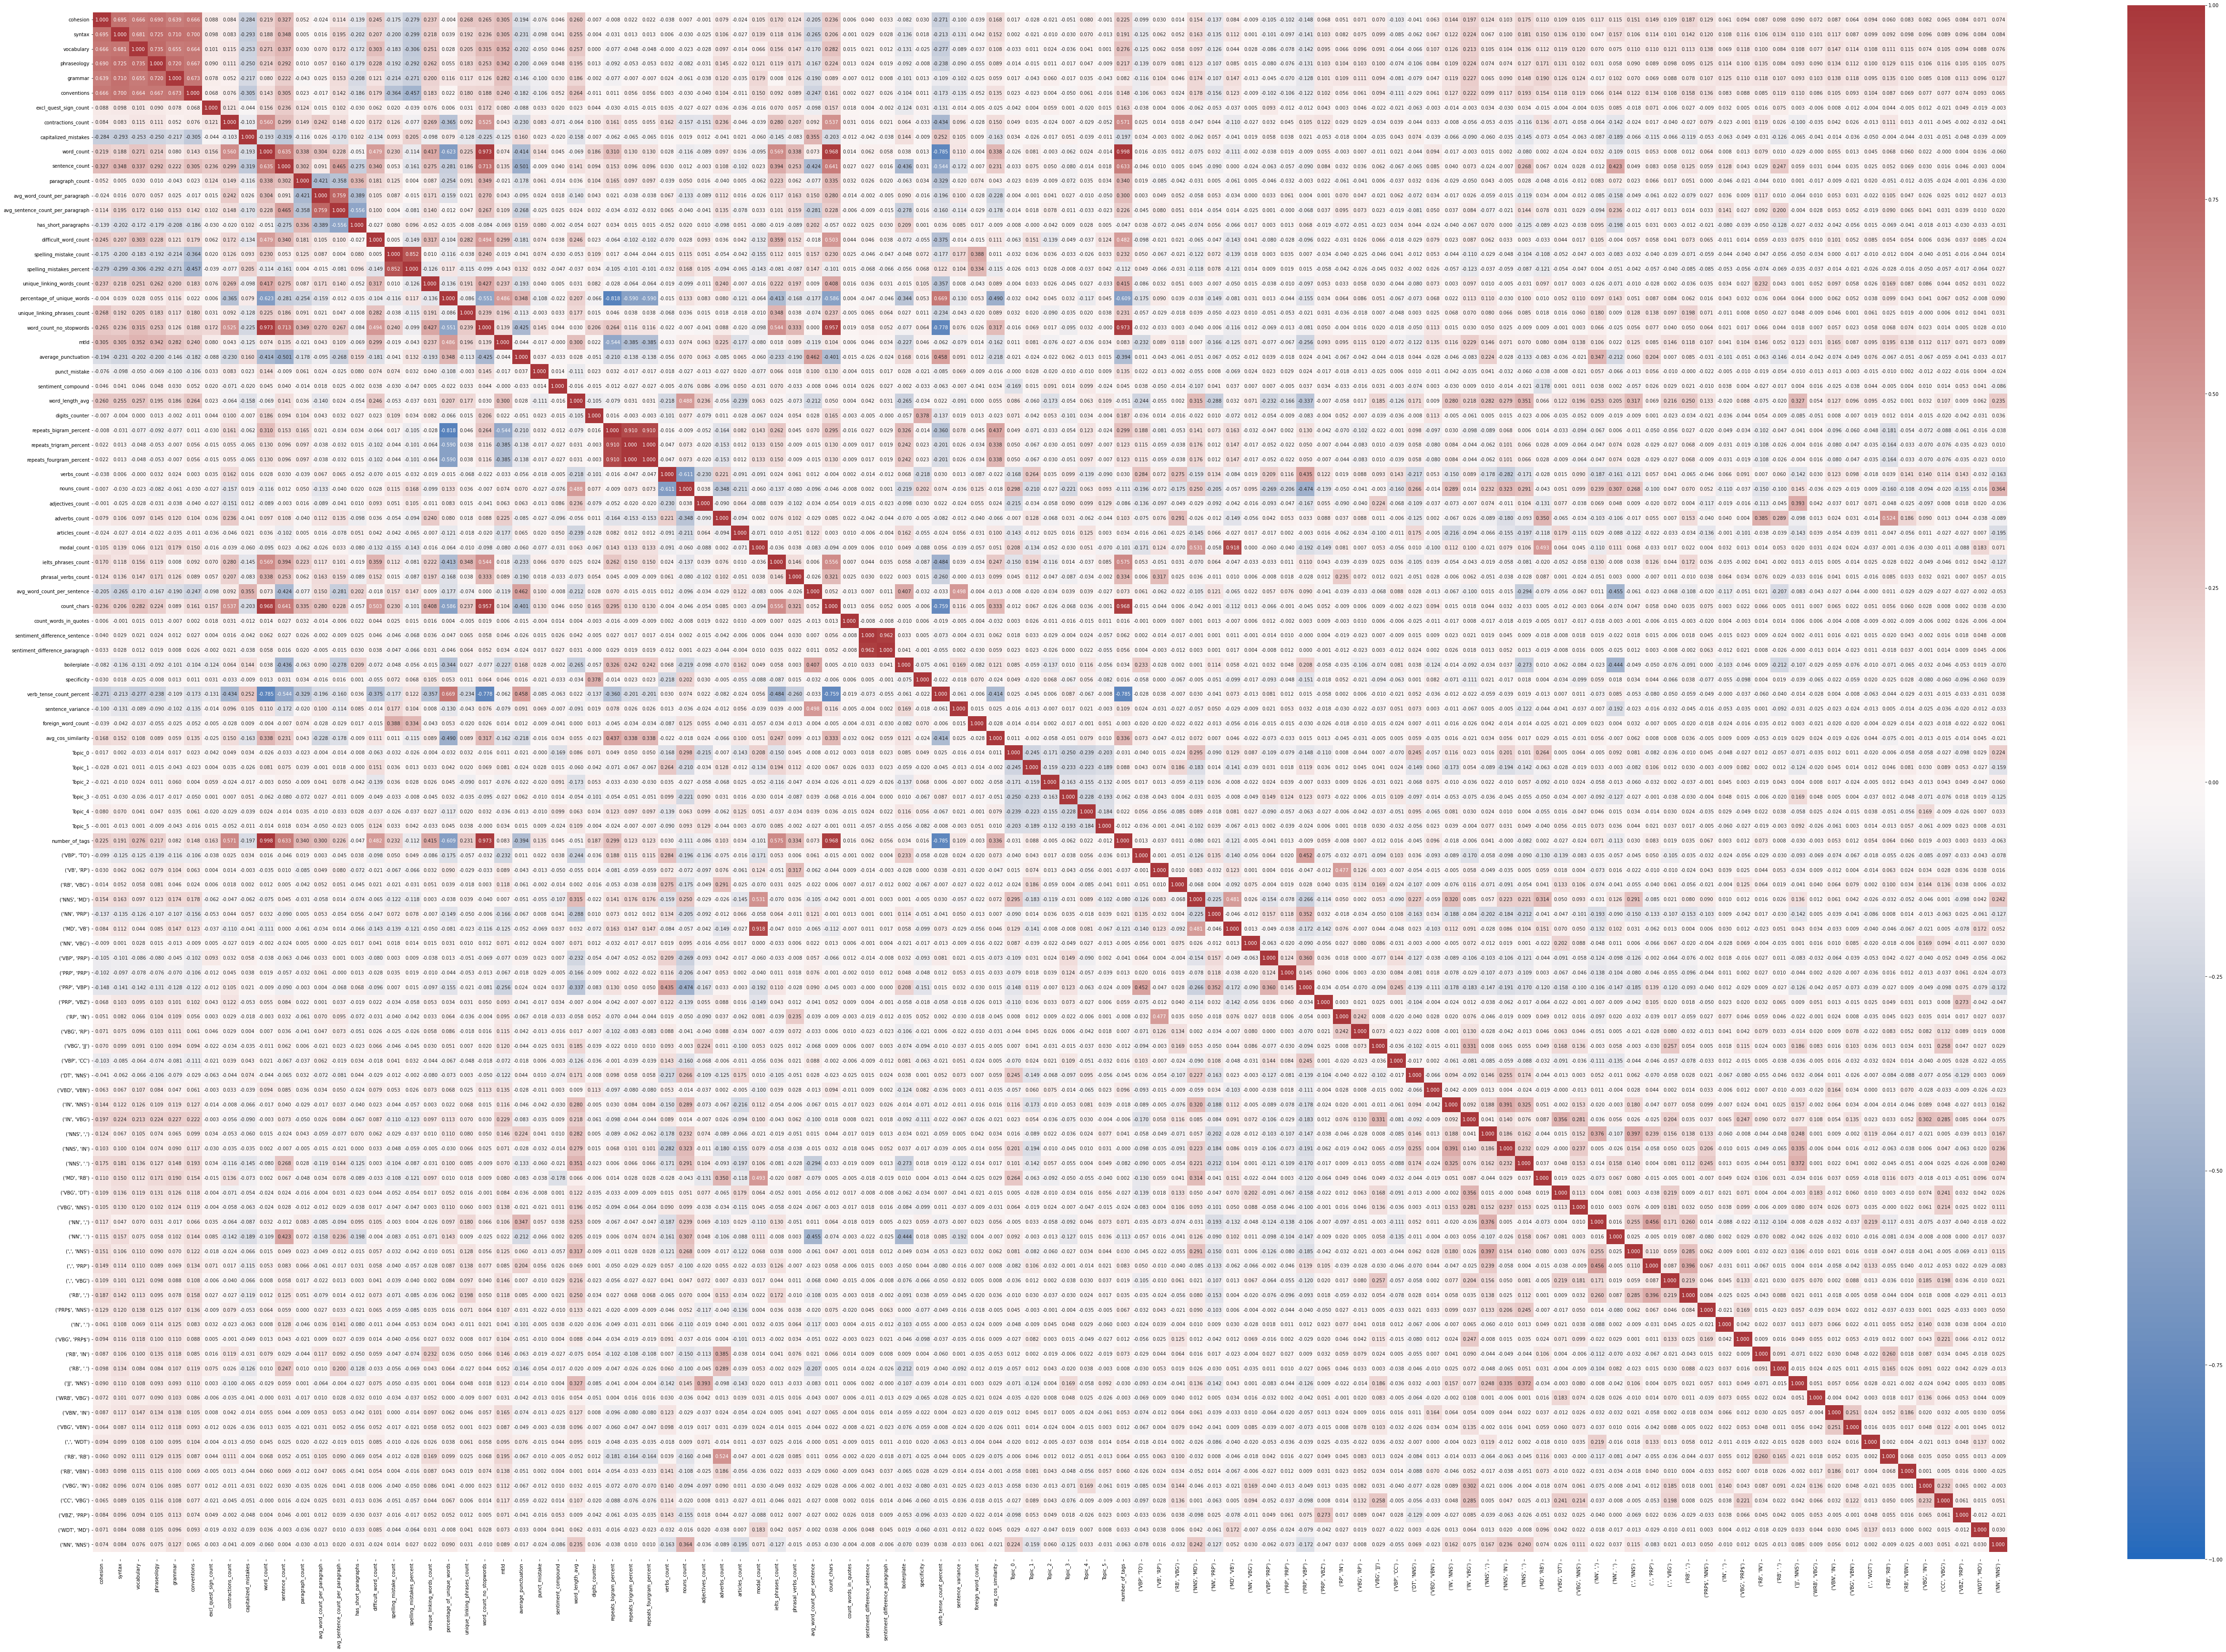

In [47]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(90, 60))

ax = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, fmt=".3f", cmap="vlag")
bottom, top = ax.get_ylim()
ax = ax.set_ylim(bottom + 0.5, top - 0.5)

In [43]:
corr_matrix = data.corr()
corr_matrix = corr_matrix[['cohesion', 'syntax', 'vocabulary',
       'phraseology', 'grammar', 'conventions']]
corr_matrix

cohesion    syntax  vocabulary  phraseology   grammar  \
cohesion     1.000000  0.695459    0.666151     0.690058  0.638689   
syntax       0.695459  1.000000    0.680562     0.725467  0.709525   
vocabulary   0.666151  0.680562    1.000000     0.735261  0.654852   
phraseology  0.690058  0.725467    0.735261     1.000000  0.719746   
grammar      0.638689  0.709525    0.654852     0.719746  1.000000   
...               ...       ...         ...          ...       ...   
(VBG, IN)    0.081794  0.095999    0.074346     0.106200  0.084868   
(CC, VBG)    0.065340  0.089434    0.104970     0.116489  0.107938   
(VBZ, PRP)   0.084314  0.095544    0.093804     0.104850  0.112745   
(WDT, MD)    0.071242  0.083755    0.087759     0.104730  0.096074   
(NN, NNS)    0.074394  0.083593    0.076404     0.074558  0.127412   

             conventions  
cohesion        0.666151  
syntax          0.700025  
vocabulary      0.664292  
phraseology     0.666842  
grammar         0.673301  
...                  ...  
(VBG, IN)       0.077486  
(CC, VBG)       0.076515  
(VBZ, PRP)      0.073758  
(WDT, MD)       0.092625  
(NN, NNS)       0.064955  

[105 rows x 6 columns]

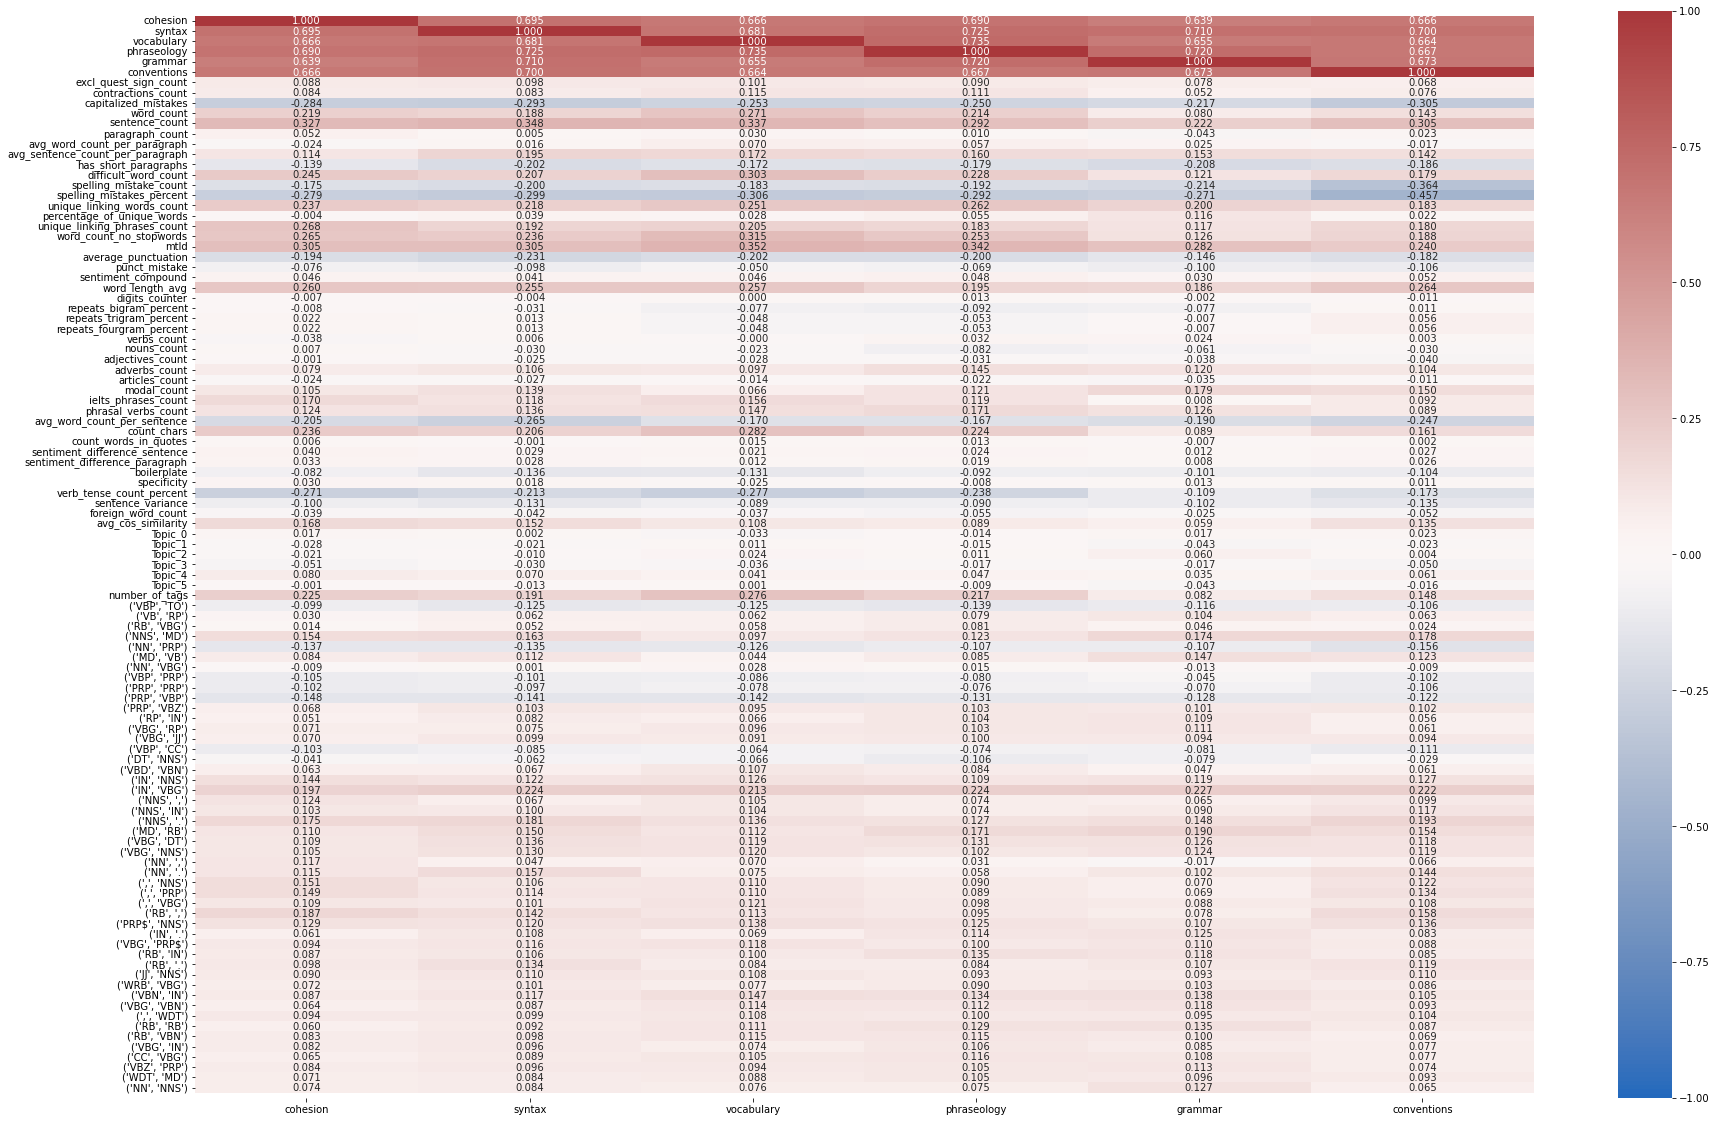

In [44]:
fig, ax = plt.subplots(figsize=(30, 20))

ax = sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, fmt=".3f", cmap="vlag")
bottom, top = ax.get_ylim()
ax = ax.set_ylim(bottom + 0.5, top - 0.5)

In [45]:
data.to_csv('../data/data_features.csv', index=False)